In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [44]:
from glob import glob
import os

data_dir = "/kaggle/input/dog-breed-identification"

train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

train_data = sorted(glob(f"{train_dir}/*"))
test_data = sorted(glob(f"{test_dir}/*"))

print(len(train_data), len(test_data))

10222 10357


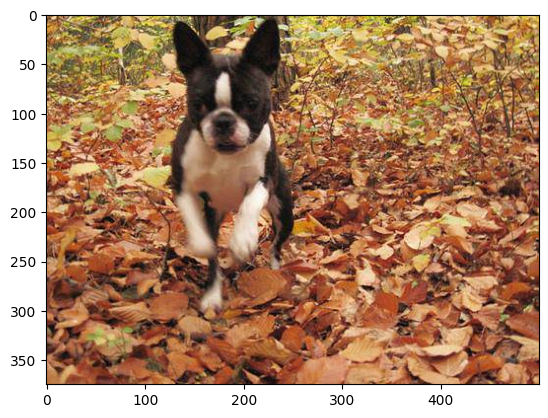

In [45]:
import matplotlib.pyplot as plt

plt.imshow(plt.imread(train_data[0]))

In [46]:
train_labels = []
with open('label.txt', 'r') as file:
    for i in file:
        train_labels.append(int(i))

In [47]:
print(len(train_labels))

10222


In [48]:
import pandas as pd
from collections import Counter
import numpy as np

# 데이터셋의 레이블이 들어있는 리스트 또는 배열
labels = np.array(train_labels)  # train_label은 120개의 라벨 리스트라고 가정

# 각 라벨의 데이터 개수를 확인
label_counts = Counter(labels)
print(f"각 라벨의 데이터 개수: {label_counts}")

# 가장 적은 데이터 개수 (예: 66개)에 맞춰서 데이터를 언더샘플링
min_count = 66  # 가장 적은 데이터 개수로 맞춤

# 새로운 데이터셋을 저장할 리스트
balanced_images = []
balanced_labels = []

# 각 라벨에 대해 언더샘플링
for label in np.unique(labels):
    # 해당 라벨의 인덱스를 모두 찾기
    label_indices = np.where(labels == label)[0]
    
    # 데이터 개수가 min_count보다 많으면 무작위로 샘플링하여 줄임
    if len(label_indices) > min_count:
        sampled_indices = np.random.choice(label_indices, min_count, replace=False)
    else:
        sampled_indices = label_indices
    
    # 샘플링된 인덱스를 기반으로 이미지와 라벨을 추가
    balanced_images.extend([train_data[i] for i in sampled_indices])
    balanced_labels.extend([train_labels[i] for i in sampled_indices])

각 라벨의 데이터 개수: Counter({97: 126, 73: 117, 1: 116, 42: 115, 11: 114, 100: 112, 52: 111, 87: 111, 7: 110, 94: 109, 109: 107, 3: 107, 26: 106, 69: 106, 9: 105, 61: 105, 6: 102, 75: 102, 13: 102, 59: 101, 68: 99, 93: 99, 84: 96, 80: 95, 101: 95, 117: 95, 88: 94, 30: 93, 60: 92, 86: 92, 55: 91, 17: 91, 78: 91, 70: 90, 102: 90, 10: 89, 35: 89, 90: 88, 56: 88, 98: 88, 19: 87, 33: 87, 82: 87, 2: 86, 95: 86, 63: 86, 39: 86, 20: 86, 15: 85, 114: 85, 14: 85, 67: 84, 92: 84, 79: 83, 40: 83, 28: 83, 118: 82, 54: 82, 57: 82, 53: 82, 8: 82, 96: 82, 64: 82, 119: 82, 71: 81, 50: 81, 116: 81, 62: 81, 37: 80, 0: 80, 110: 80, 74: 80, 31: 80, 115: 79, 111: 79, 104: 79, 105: 79, 76: 79, 58: 78, 5: 78, 77: 78, 81: 78, 107: 78, 12: 77, 99: 76, 36: 76, 27: 76, 91: 76, 85: 75, 18: 75, 21: 75, 25: 75, 51: 75, 47: 75, 41: 75, 38: 74, 4: 74, 32: 74, 24: 73, 72: 73, 89: 72, 106: 72, 16: 72, 44: 72, 34: 72, 66: 71, 29: 71, 103: 71, 112: 70, 45: 70, 113: 69, 83: 69, 48: 69, 46: 69, 108: 69, 49: 67, 65: 67, 22: 67, 43:

In [49]:
print(len(balanced_images))
print(len(balanced_labels))

7920
7920


In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import ConcatDataset

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import numpy as np

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [52]:
model = models.efficientnet_b2(pretrained=True)

# class CustomModel(nn.Module):
#     def __init__(self, model):
#         super(CustomModel, self).__init__()
#         self.model = model
#         self.linear = nn.Linear(1000, 120)
        
#     def forward(self, x):
#         x = self.model(x)
#         x = self.linear(x)
    
#         return x
    
# model = CustomModel(model)

model.classifier[0] = nn.Dropout(p=0.1, inplace=True)
model.classifier[1] = nn.Linear(in_features=1408, out_features=120, bias=True)

model.to(device)
# print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [53]:
from PIL import Image
import cv2
import requests

class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, path, y, transform, noise_type=None, noise_level=0.1):
        self.path = path
        self.y = y
        self.transform = transform
        self.noise_type = noise_type
        self.noise_level = noise_level  # 노이즈 강도 (0.1 = 10%)
        
    def __len__(self):
        return len(self.y)
    
    def add_noise(self, image):
        # 가우시안 노이즈 추가
        if self.noise_type == 'gaussian':
            row, col, ch = image.shape
            mean = 0
            sigma = self.noise_level * 255
            gauss = np.random.normal(mean, sigma, (row, col, ch))
            gauss = gauss.reshape(row, col, ch)
            noisy = image + gauss
            return np.clip(noisy, 0, 255).astype(np.uint8)
        
        # 소금-후추 노이즈 추가
        elif self.noise_type == 'salt_pepper':
            s_vs_p = 0.5
            amount = self.noise_level
            noisy = np.copy(image)

            # 소금 노이즈 (하얀 점)
            num_salt = np.ceil(amount * image.size * s_vs_p)
            coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
            noisy[coords[0], coords[1], :] = 255

            # 후추 노이즈 (검은 점)
            num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
            coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
            noisy[coords[0], coords[1], :] = 0

            return noisy

        return image  # 노이즈가 없으면 원본 이미지 반환
    
    def __getitem__(self, index):
        x = cv2.imread(self.path[index])
        
        if self.noise_type is not None:
            x = self.add_noise(x)
            
        x = Image.fromarray(x)
        x = self.transform(x)
        
        y = self.y[index]
        
        return x, y

In [54]:
from sklearn.model_selection import train_test_split

train_image, val_image, train_label, val_label = train_test_split(balanced_images, balanced_labels, test_size=0.3, stratify=balanced_labels)

In [55]:
print(len(train_image), len(val_image), len(train_label), len(val_label))

5544 2376 5544 2376


In [56]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.3920, 0.4519, 0.4763), (0.2155, 0.2173, 0.2227))
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.3920, 0.4519, 0.4763), (0.2155, 0.2173, 0.2227))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.3920, 0.4519, 0.4763), (0.2155, 0.2173, 0.2227))
])

In [58]:
original_ds = custom_dataset(train_image, train_label, train_transform)
gaussian_ds = custom_dataset(train_image, train_label, train_transform, noise_type='gaussian', noise_level=0.3)
salt_pepper_ds = custom_dataset(train_image, train_label, train_transform, noise_type='salt_pepper', noise_level=0.05)

In [59]:
train_ds = ConcatDataset([original_ds, gaussian_ds, salt_pepper_ds])
val_ds = custom_dataset(val_image, val_label, val_transform)

In [60]:
print(len(train_ds))

16632


레이블: briard


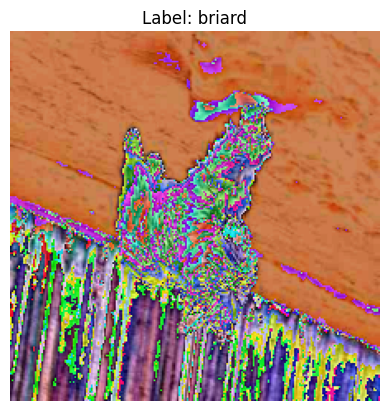

In [61]:
from torchvision.transforms.functional import to_pil_image

class_names = label_df['breed'].unique()
class_names = sorted(class_names)
# class_names

# combined_dataset에서 0번째 이미지를 꺼내오기
image, label = train_ds[5000]  # 인덱스를 통해 특정 데이터 꺼내기

label = class_names[label]
# 이미지와 레이블 확인
print(f"레이블: {label}")

# 이미지를 시각화 (이미지 텐서를 PIL 이미지로 변환 후 보여줌)
if isinstance(image, torch.Tensor):
    image = to_pil_image(image)  # 텐서를 PIL 이미지로 변환 (transform 적용 시 텐서로 반환됨)

# 이미지 시각화
plt.imshow(np.asarray(image))
plt.title(f"Label: {label}")
plt.axis('off')  # 축 제거
plt.show()

In [36]:
# train_ds = custom_dataset(train_image, train_label, train_transform)
# val_ds = custom_dataset(val_image, val_label, val_transform)

In [62]:
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=64)

In [63]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [64]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.3)

In [65]:
from sklearn.metrics import accuracy_score
import tqdm

def train_validate(model, train_dataloader, test_loader, optimizer, loss_func, epochs):
    train_losses = []
    train_accs = []
    validation_losses = []
    validation_accs = []

    for epoch in range(epochs):
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        model.train()

        # 훈련 루프
        for data, target in tqdm.tqdm(train_dataloader):
            
            data = data.to(device)
            target = target.to(device)
            
            y_pred = model(data)
#             print(y_pred.shape)
            loss = loss_func(y_pred, target)

            acc = accuracy_score(target.cpu(), y_pred.argmax(dim=1).detach().cpu())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            epoch_train_acc += acc

        # 에포크 당 평균 훈련 손실 및 정확도
        avg_train_loss = epoch_train_loss / len(train_dataloader)
        avg_train_acc = epoch_train_acc / len(train_dataloader)

        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)

        print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")

        # 검증 루프
        model.eval()
        epoch_validation_loss = 0.0
        with torch.no_grad():
            for data, target in tqdm.tqdm(test_loader):
                
                data = data.to(device)
                target = target.to(device)

                y_pred = model(data)

                loss = loss_func(y_pred, target)

                epoch_validation_loss += loss.item()
        
        avg_validation_loss = epoch_validation_loss / len(test_loader)
        avg_validation_acc = accuracy_score(target.cpu(), y_pred.argmax(dim=1).detach().cpu())
        
        validation_losses.append(avg_validation_loss)
        validation_accs.append(avg_validation_acc)

        print(f"Validation Loss: {avg_validation_loss:.4f}, Validation Acc: {avg_validation_acc:.4f} \n")
        
        torch.save(model.state_dict(), f"model_{epoch}.pth")
        
    return train_losses, train_accs, validation_losses, validation_accs

In [66]:
epochs=5

In [67]:
train_losses, train_accs, validation_losses, validation_accs = train_validate(model, train_dataloader, val_dataloader, optimizer, criterion, epochs)

100%|██████████| 259/259 [04:36<00:00,  1.07s/it]


Epoch: 1, Train Loss: 2.5343, Train Acc: 0.3545


100%|██████████| 38/38 [00:18<00:00,  2.10it/s]


Validation Loss: 1.6818, Validation Acc: 0.7500 



100%|██████████| 259/259 [04:31<00:00,  1.05s/it]


Epoch: 2, Train Loss: 1.0744, Train Acc: 0.6873


100%|██████████| 38/38 [00:14<00:00,  2.70it/s]


Validation Loss: 1.6975, Validation Acc: 0.7500 



100%|██████████| 259/259 [04:29<00:00,  1.04s/it]


Epoch: 3, Train Loss: 0.5492, Train Acc: 0.8326


100%|██████████| 38/38 [00:14<00:00,  2.71it/s]


Validation Loss: 1.8229, Validation Acc: 0.7500 



100%|██████████| 259/259 [04:29<00:00,  1.04s/it]


Epoch: 4, Train Loss: 0.3291, Train Acc: 0.9008


100%|██████████| 38/38 [00:14<00:00,  2.70it/s]


Validation Loss: 2.0661, Validation Acc: 0.6250 



100%|██████████| 259/259 [04:30<00:00,  1.05s/it]


Epoch: 5, Train Loss: 0.2330, Train Acc: 0.9306


100%|██████████| 38/38 [00:14<00:00,  2.68it/s]

Validation Loss: 2.0974, Validation Acc: 0.7500 



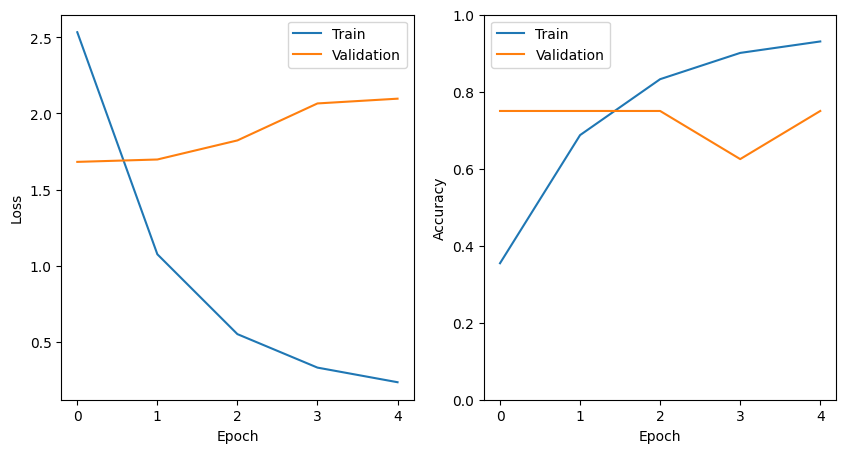

In [68]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(validation_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(validation_accs, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [69]:
model.load_state_dict(torch.load("model_4.pth"))
# model2 = model.load_state_dict(torch.load("model_1.pth"))
# model3 = model.load_state_dict(torch.load("model_2.pth"))
# model4 = model.load_state_dict(torch.load("model_3.pth"))
# model5 = model.load_state_dict(torch.load("model_4.pth"))

/tmp/ipykernel_36/3496939725.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_4.pth"))


<All keys matched successfully>

In [70]:
def predict(model, dataloader):
    model.eval()  # 평가 모드로 전환
    all_preds = []

    with torch.no_grad():  # 그래디언트 계산 비활성화

        for data in dataloader:
            data = data.to(device)  # 데이터를 장치로 이동
            
            # 모델 예측
            outputs = model(data)
            # preds = outputs.argmax(dim=1)
            
            probabilities = F.softmax(outputs, dim=1)

            # # 예측값을 리스트에 추가
            all_preds.append(probabilities.cpu().numpy())

    return all_preds

In [71]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform):
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.path)

    def __getitem__(self, index):
        x = cv2.imread(self.path[index])
        x = Image.fromarray(x)
        x = self.transform(x)

        return x

In [72]:
test_ds = TestDataset(test_data, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=32)

In [73]:
preds1 = predict(model, test_dataloader)
# preds2 = predict(model, test_dataloader)
# preds3 = predict(model, test_dataloader)
# preds4 = predict(model, test_dataloader)
# preds5 = predict(model, test_dataloader)

In [74]:
real_preds = [row for matrix in preds1 for row in matrix]

In [75]:
test_data_id = []

for i in range(len(test_data)):
    temp = test_data[i].split('/')[-1].split('.jpg')[0]
    test_data_id.append(temp)

len(test_data_id)

10357

In [76]:
import pandas as pd

label_df = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
# label_df

id_df = pd.DataFrame({'id' : test_data_id})
# id_df

result_df = pd.DataFrame(real_preds, columns=class_names)
# result_df

In [77]:
real_result = pd.concat([id_df, result_df], axis=1)
real_result.to_csv('answer5.csv', index=False)

In [29]:
# grad-cam
!pip install grad-cam torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.3-py3-none-any.whl size=38657 sha256=28a1257853a28f74aa77e943360c803887ffb02b5419c245469c5e841500053f
  Stored in directory: /root/.cache/pip/wheels/2e/ce/70/fe64f851895eae830b3c63ec7fc464cfa7c81aeb7ad4f68063
Successfully built grad-cam


In [30]:
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam import DeepFeatureFactorization
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, XGradCAM, LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image, show_factorization_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [31]:
test_answer_df = pd.read_csv('/kaggle/working/answer4.csv')
float_columns = test_answer_df.select_dtypes(include=['float'])
max_column = float_columns.iloc[1].idxmax()
answer = class_names.index(max_column)
answer

94

In [32]:
test_image = cv2.imread(test_data[1])
test_image = Image.fromarray(test_image)

input_tensor = test_transform(test_image).unsqueeze(0).to(device)

target_layers = [model.features[-1]]

targets = [ClassifierOutputTarget(answer)]

target_layers

[Conv2dNormActivation(
   (0): Conv2d(352, 1408, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (1): BatchNorm2d(1408, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): SiLU(inplace=True)
 )]

In [33]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, XGradCAM, LayerCAM

grad_cam = GradCAM(model=model, target_layers=target_layers)
grad_cam_map = grad_cam(input_tensor=input_tensor, targets=targets)[0]

grad_cam_plus_plus = GradCAMPlusPlus(model=model, target_layers=target_layers)
grad_cam_plus_plus_map = grad_cam_plus_plus(input_tensor=input_tensor, targets=targets)[0]

x_grad_cam = XGradCAM(model=model, target_layers=target_layers)
x_grad_cam_map = x_grad_cam(input_tensor=input_tensor, targets=targets)[0]

layer_cam = LayerCAM(model=model, target_layers=target_layers)
layer_cam_map = layer_cam(input_tensor=input_tensor, targets=targets)[0]

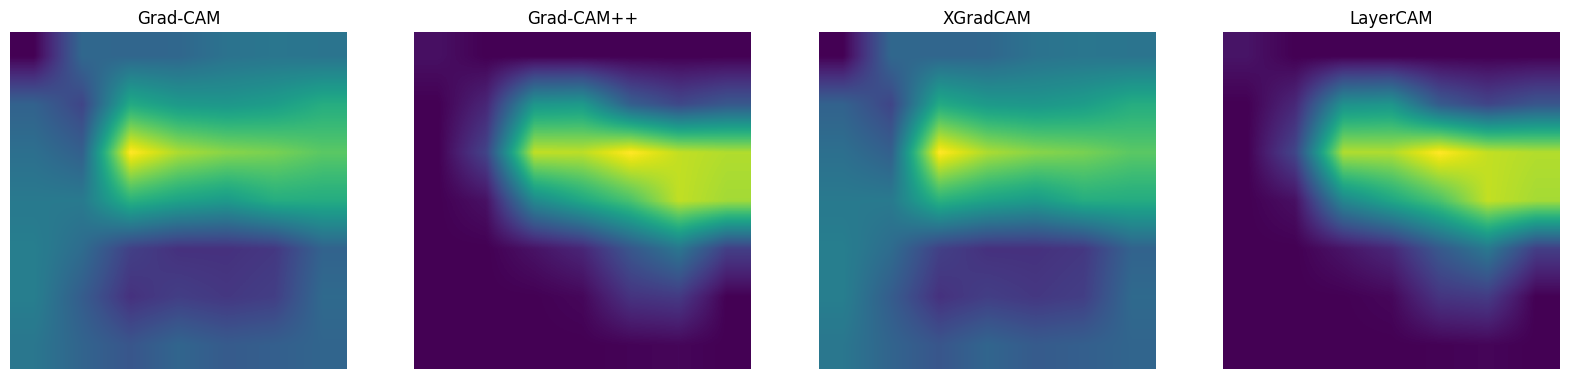

In [34]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# GradCAM
axs[0].imshow(grad_cam_map)
axs[0].title.set_text('Grad-CAM')
axs[0].axis('off')

# GradCAMPlusPlus
axs[1].imshow(grad_cam_plus_plus_map)
axs[1].title.set_text('Grad-CAM++')
axs[1].axis('off')

# XGradCAM
axs[2].imshow(x_grad_cam_map)
axs[2].title.set_text('XGradCAM')
axs[2].axis('off')

# LayerCAM
axs[3].imshow(layer_cam_map)
axs[3].title.set_text('LayerCAM')
axs[3].axis('off')

plt.show()

In [35]:
import torchcam
from torchcam.utils import overlay_mask

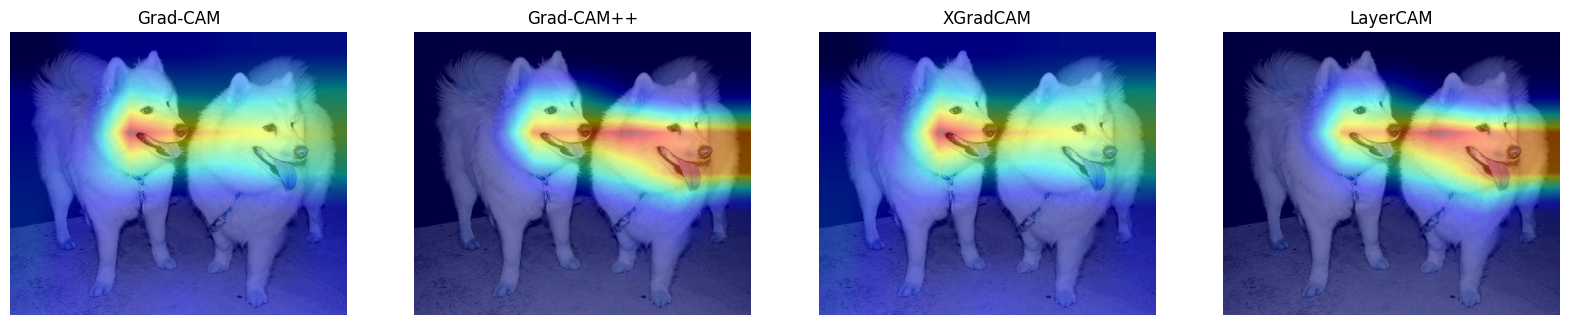

In [36]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# GradCAM
grad_cam_overlay = overlay_mask(test_image, Image.fromarray(grad_cam_map), alpha=0.5)
axs[0].imshow(grad_cam_overlay)
axs[0].title.set_text('Grad-CAM')
axs[0].axis('off')

# GradCAMPlusPlus
grad_cam_plus_plus_overlay = overlay_mask(test_image, Image.fromarray(grad_cam_plus_plus_map), alpha=0.5)
axs[1].imshow(grad_cam_plus_plus_overlay)
axs[1].title.set_text('Grad-CAM++')
axs[1].axis('off')

# XGradCAM
x_grad_cam_overlay = overlay_mask(test_image, Image.fromarray(x_grad_cam_map), alpha=0.5)
axs[2].imshow(x_grad_cam_overlay)
axs[2].title.set_text('XGradCAM')
axs[2].axis('off')

# LayerCAM
layer_cam_overlay = overlay_mask(test_image, Image.fromarray(layer_cam_map), alpha=0.5)
axs[3].imshow(layer_cam_overlay)
axs[3].title.set_text('LayerCAM')
axs[3].axis('off')

plt.show()

In [7]:
# import pandas as pd

# label_df = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
# # label_df

# class_names = label_df['breed'].unique()
# class_names = sorted(class_names)
# print(class_names)

# label_dict = dict(zip(label_df.iloc[:, 0], label_df.iloc[:, 1]))
# print(label_dict)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

In [8]:
# train_label = []
# for i in range(len(train_data)):
#     label_str = label_dict[train_data[i].split('/')[-1].split('.jpg')[0]]
#     label_index = class_names.index(label_str)
# #     print(label_index, label_str)
#     train_label.append(label_index)

# file_name = './label.txt'

# with open(file_name, 'w') as file:
#     for item in train_label:
#         file.write(str(item) + '\n')

In [51]:
# mean = 0.0
# std = 0.0
# n_samples = 0

# for images, _ in train_dataloader:
#     # 이미지의 배치 크기 (B, C, H, W)
#     batch_samples = images.size(0)  # 배치 내 이미지 수
#     images = images.view(batch_samples, images.size(1), -1)  # (B, C, H*W)
    
#     # 배치 평균과 표준편차 계산
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)
#     n_samples += batch_samples

# # 평균과 표준편차 최종 값
# mean /= n_samples
# std /= n_samples

# print(mean, std)